# Предсказание оттока клиентов телекоммуникационной компании

## Описание задачи

### Введение

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

В нашем распоряжении 4 датафрейма.

Данные состоят из файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
    - BeginDate - дата начала пользования услугами
    - EndDate - дата окончания пользования услугами
    - Type - тип договора: ежемесячный, годовой и т.д
    - PaperlessBilling - выставления счёта по электронной почте
    - PaymentMethod - способ оплаты
    - MonthlyCharges - ежемесячные траты на услуги
    - TotalCharges - всего потрачено денег на услуги
    
    
- personal_new.csv — персональные данные клиента;
    - gender - пол
    - SeniorCitizen - наличие пенсионного статуса по возрасту
    - Partner - наличие супруга/супруги
    - Dependents - наличие иждивенцев
    
    
- internet_new.csv — информация об интернет-услугах;
    - InternetService - наличие услуг Интернет
    - OnlineSecurity - межсетевой экран
    - OnlineBackup - облачное хранилище файлов для резервного копирования данных
    - DeviceProtection - антивирус
    - TechSupport - выделенная линия технической поддержки
    - StreamingTV - онлайн-ТВ
    - StreamingMovies - онлайн-кинотеатр
    
    
- phone_new.csv — информация об услугах телефонии.
    - MultipleLines - возможность подключения телефонного аппарата к нескольким линиям одновременно
    
Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Постановка задачи

Перед нами стоит задача бинарной классификации. Нужно предсказать уход клиента, т.е. отказ от пользования услугами компании.

Целевой признак необходимо будет создать на основе окончания контракта по признаку `EndDate`.

В качестве основной метрики будем использовать ROC-AUC. За успешный порог примем ROC-AUC >= 0.85.

Также для простоты интерпретации закзчика интересует метрика accuracy на тестовой выборке и матрица ошибок.

### План работы

- Загрузка и ознакомление с данными
- Предобработка данных
    - Объединение данных
    - Обработка возникших пропусков
    - Выделение целевого признака
    - Изменение типов данных
- Исследование данных
    - Проверка признаков на мультиколлинеарность
    - Исследование баланса классов
- Продолжение предобработки
    - Удаление лишних признаков
- Обучение нескольких типов моделей и проверка кросс-валидацией
    - Разделение на тренировочную и тестовую выборки
    - Кодирование по необходимости
    - Обучение с кросс-валидацией
    - Выбор лучшей модели
- Проверка лучшей модели на тестовой выбоке
    - Построение ROC-кривой
    - Рассчет accuracy
    - Матрица ошибок
    - Оценка важности признаков
- Анализ результатов и итоговый отчет

## Загрузка и ознакомление с данными

### Загрузка

Загрузим необходимые библиотеки

In [2]:
# потребуется для необходимых действий с OneHotEncoder
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 48 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [3]:
# нужна для проверки корреляции категориальных признаков
!pip install phik

     |████████████████████████████████| 679 kB 1.1 MB/s eta 0:00:01


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LogisticRegression, 
    RidgeClassifier
)
from sklearn.metrics import (
    auc, 
    roc_curve, 
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.dummy import DummyClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

RANDOM_STATE = 140823

Загрузим датафреймы

In [5]:
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

### Ознакомление

Создадим функцию для получения основной информации по датафрейму

In [6]:
def get_info(data):
    data.info()
    display(data.head())
    display(data.describe(include='all'))
    print('Кол-во дуликатов:', data.duplicated().sum())

И теперь взгянем на 4 полученных датафрейма

In [7]:
get_info(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,2378-VTKDH,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Кол-во дуликатов: 0


In [8]:
get_info(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,2378-VTKDH,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


Кол-во дуликатов: 0


In [9]:
get_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,5482-PLVPE,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Кол-во дуликатов: 0


In [10]:
get_info(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,9435-JMLSX,No
freq,1,3390


Кол-во дуликатов: 0


### Выводы

Дубликатов в двнных нет.

Большинство признаков категориальные, причем большая часть бинарные(Yes/No или 1/0).

Признак TotalCharges определен как object, хотя явно числовой, надо проверить и привести к правильному типу.

В таблицах contract и personal одинаковое кол-во строк, а в internet и phone меньше. Это верятно связано с тем, что не все клиенты пользуются и теми и другими услугами, и в таблицы заносили только пользователей с подключенными услугами.

## Предобработка данных

### Объединение данных

Объединим наши 4 датафрейма в 1

In [11]:
df = (contract.merge(personal, on='customerID')
              .merge(internet, on='customerID', how='left')
              .merge(phone, on='customerID', how='left'))

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


### Обработка возникших пропусков

In [13]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

В колонках InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines возникли пропуски из-за слияния таблиц. Заполним эти пропуски новым значением 'NoUse'

In [14]:
for column in ['InternetService', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV',
               'StreamingMovies', 'MultipleLines']:
    df[column] = df[column].fillna('NoUse')

In [15]:
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

### Создание целевого признака

Рассмотрим колонку EndDate, на основе которой создадим целевой признак

In [16]:
df['EndDate'].value_counts().sort_index().to_frame()

,EndDate
2014-06-01,1
2014-09-01,2
2014-10-01,1
2014-11-01,1
2014-12-01,2
...,...
2019-10-01,31
2019-11-01,30
2019-12-01,38
2020-01-01,39


Как видно, в EndDate записана дата ухода клиента, либо No, если клиент все еще действующий. Создадим новый целевой признак равный 1, если клиент ушел, и 0, если не ушел.

In [17]:
df['Leave'] = (df['EndDate'] != 'No').astype(int)

In [18]:
df.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Leave
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NoUse,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NoUse,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,...,No,DSL,Yes,No,No,No,No,No,NoUse,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,...,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,...,Yes,DSL,Yes,Yes,No,No,No,No,No,1


### Создание нового признака

Признак EndDate надо будет удалить, поскольку он практически является целевым. Но можем воспользоваться им для создания нового - врямя пользования услугами компании.

Заменим значения No в EndDate на 1 февраля 2020, поскольку мы рассматриваем данные только до этого момента. И вычислим разность между EndDate и BeginDate.

In [19]:
df.loc[df.EndDate == 'No', 'EndDate'] = '2020-02-01'

Приведем EndDate и BeginDate к формату даты

In [20]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')

Вычислим разницу между датами в днях, поскольку модель лучше отзовется на такую единицу измерения, чем на месяцы, как предполагалось изначально.

In [22]:
df['Days_of_use'] = (df['EndDate'] - df['BeginDate']).dt.days

In [23]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Leave,Days_of_use
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,NoUse,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,NoUse,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


### Изменение типов данных

#### TotalCharges

Рассмотрим столбец TotalCharges

In [24]:
df['TotalCharges'].value_counts().sort_index().to_frame()

,TotalCharges
,11
100.17,1
100.19,1
100.2,1
100.24,1
...,...
997.05,1
997.78,1
998.89,1
999.6,2


Видим, что 11 строк заполнены странным значением ' '. Вероятно, эти клиенты вообще не тратили денег на услуги компании.

Приведем столбец к числовому типу и заполним пропуски 0. 

In [25]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [26]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [27]:
df['TotalCharges'].value_counts().sort_index().to_frame()

,TotalCharges
0.00,11
19.05,1
19.10,2
19.19,1
19.20,3
...,...
8957.52,1
8998.27,1
9068.36,1
9218.88,1


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

#### SeniorCitizen

Посколько большинстово бинарных признаков в нашем датафрейме заполнены Yes/No, изменим 1/0 в столбце SeniorCitizen также на Yes/No во избежание путаницы с численным признаком.

In [29]:
df['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [30]:
# метод map заменияет значения в столбце по словарю, 
# где ключи текущие значения столбца, а значения словаря - те на которые мы хотим заменить
df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

In [31]:
df['SeniorCitizen'].value_counts()

No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64

### Удаление customerID

Удалим столбец 'customerID', т.к. он не несет полезной для модели информации и нужен был нам для объединения таблиц.

In [32]:
df = df.drop(['customerID'], axis=1)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtection  7043 n

### Выводы

Мы объединилили 4 исходных датафрейма в один общий.

Заполнили возникшие ппосле объединения пропуски новым значением `'NoUse'`, чтобы не смешивать тех кто вообще не пользуется телефонией/интернетом с теми кто не пользуется только некоторыми функциями.

Создали целевой признак `'Leave'` равный 1, если клиент ушел, и 0, если не ушел.

Создали новый признак `'Days_of_use'` - врямя пользования услугами компании в месяцах.

После исследования данных надо будет удалить признаки 'EndDate', 'BeginDate', т.к. они приведут к утечке данных.

## Исследование данных

### Исследование признаков

Посмотрим внимательнее на признаки, для этого создадим несколько дополнительных функций

In [34]:
def hist_n_box(column, hue='Leave'):
    '''
    Функция строит гистограмму и ящик с усами для заданного чесленного признака.
    Параметр hue разбивает данные по целевому признаку
    '''
    # создаем фигуру из двух графиков (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10, 7))

    # прописывем каждый график
    sns.boxplot(data=df, x=column, ax=ax_box, y=hue, orient='h')
    sns.histplot(data=df, x=column, ax=ax_hist, kde=True, hue=hue)
    ax_hist.grid(visible=True)
    ax_hist.set(ylabel='Кол-во значений')

    # общий заголовок
    plt.suptitle(f'Распределение столбца {column}', y=0.94, fontsize=15)

    # убираем дублирующую подпись по ОХ у первого графика
    ax_box.set(xlabel='')
    plt.show()

In [36]:
def hist_cat(column, hue='Leave', norm=False):
    '''
    Функция строит гистограмму для заданного категориального признака
    Параметр hue разбивает данные по целевому признаку
    Параметр norm=True добавляет нормированную диаграмму
    '''
    # кол-во уникальных значений, чтобы задать bins
    uni = len(df[column].unique())
    
    # если уникальных значений большей 5 ориентируем график вертикально
    if uni > 5:
        # задаем размер
        plt.figure(figsize=(11,7))
        
        # задаем сам график
        sns.histplot(data=df, x=df[column], hue=hue, multiple='stack', bins=uni)
        
        # подписываем ось
        plt.ylabel('Кол-во значений')
        
        # подписываем график
        plt.title(f'Распределение столбца {column}', fontsize=15)
        
        # добавляем нормированную диаграмму
        if norm == True:
            plt.figure(figsize=(11,7))
            sns.histplot(data=df, x=df[column], hue=hue, multiple='fill', bins=uni)
            plt.ylabel('Кол-во значений')  
            plt.title(f'Нормированное распределение столбца {column}', fontsize=15)
        
    # если уникальных значений меньше ориентируем график горизонтально
    else:
        plt.figure(figsize=(11,1))
        sns.histplot(data=df, y=df[column], hue=hue, multiple='stack', bins=uni)
        plt.xlabel('Кол-во значений')
        plt.title(f'Распределение столбца {column}', fontsize=15)
    
        if norm == True:
            plt.figure(figsize=(11,1))
            sns.histplot(data=df, y=df[column], hue=hue, multiple='fill', bins=uni)
            plt.xlabel('Кол-во значений')
            plt.title(f'Нормированное распределение столбца {column}', fontsize=15)

#### BeginDate

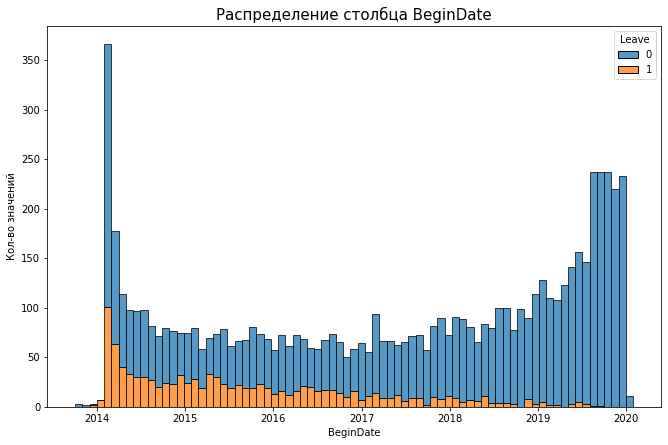

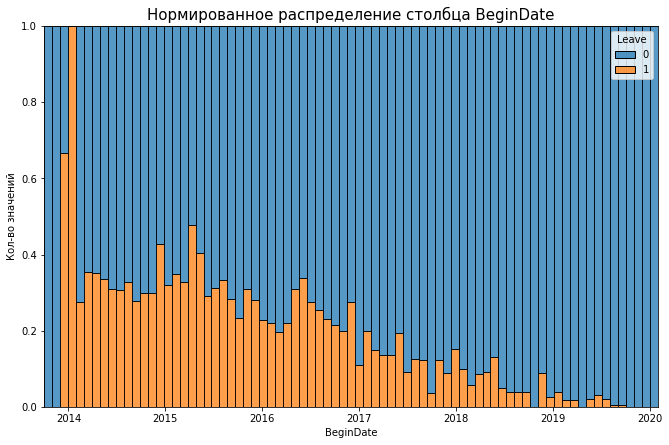

In [37]:
hist_cat('BeginDate', norm=True)

Видим, что за последний год стало приходить больше новых пользователей.

При этом ушедшими пользователями, в основном, являются пользователи пришедшие давно.

#### EndDate

Обрежем ось y, чтобы нас не отвлекал созданный нами выброс '2020-02-01' вместо 'No'

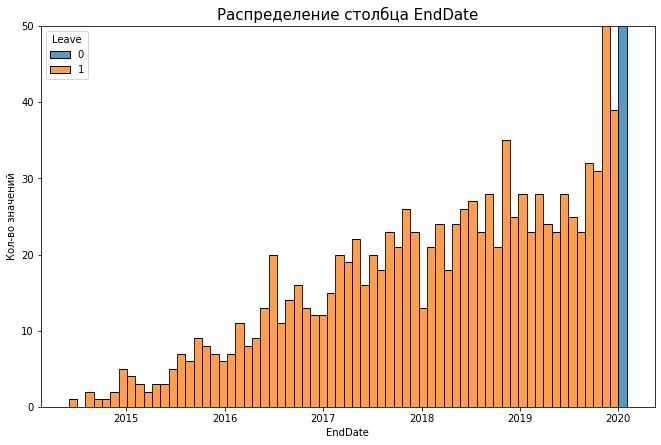

In [38]:
hist_cat('EndDate')
plt.ylim(0, 50);

Видим, что количество ушедших пользователей увеличивается со временем

#### Type

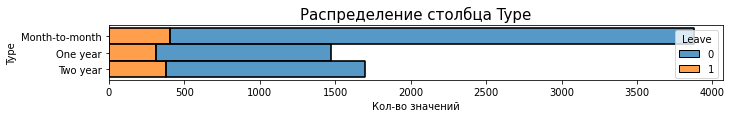

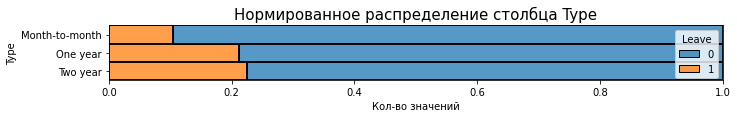

In [39]:
hist_cat('Type', norm=True)

Большинство пользовательей платят помясячно. Количество ушедших в каждой группе примерно одинаково. При этом доля ушедших меньше среди платяших ежемесячно.

#### PaperlessBilling

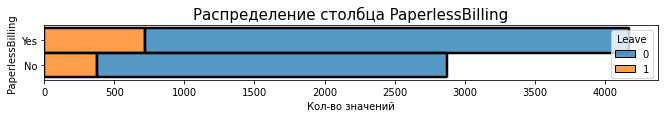

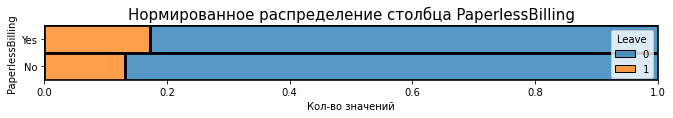

In [40]:
hist_cat('PaperlessBilling', norm=True)

Выставления счёта по электронной почте у большего числа клиентов. Распределение ушедших клинтов примерно пропорционально.

#### PaymentMethod

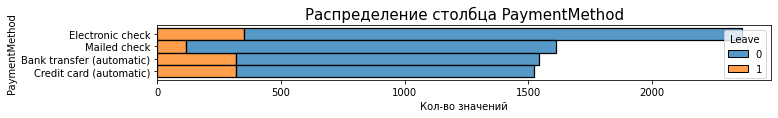

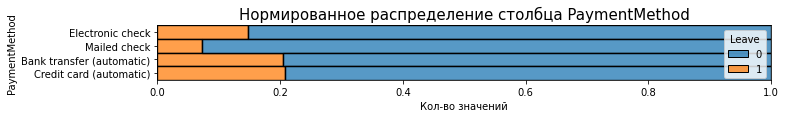

In [41]:
hist_cat('PaymentMethod', norm=True)

Больше всего используют электронный чек, при этом меньше всего ушедших среди тех, кто получает чек по почте.

#### MonthlyCharges

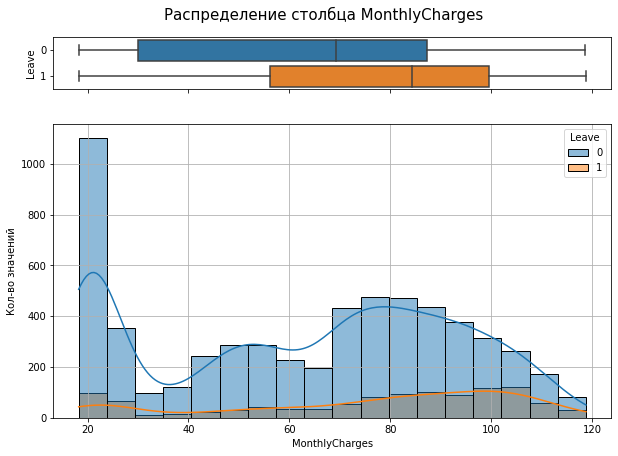

In [42]:
hist_n_box('MonthlyCharges')

Первый пик вероятно показывает людей, которые не используют дополнительные услуги и вносят минимальный платеж.

Среди остальных клиентов видим пик в районе 80.

Видим, что больше ушедших среди тех, кто больше тратит за услуги.

#### TotalCharges

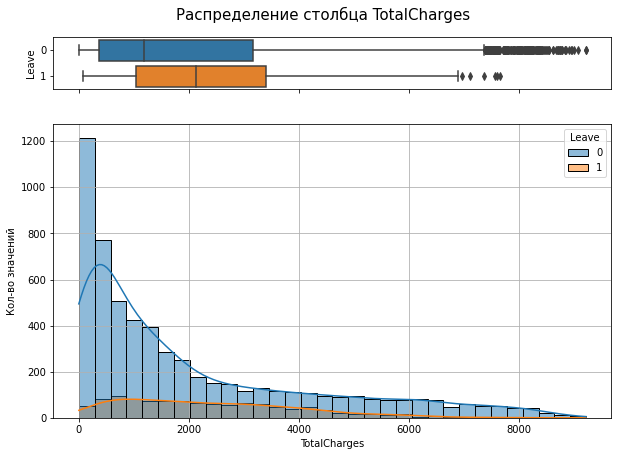

In [43]:
hist_n_box('TotalCharges')

Распределение вполне ожидаемое, кол-во клиентов с большими потраченными суммами уменьшается, с увеличением суммы трат.

#### gender

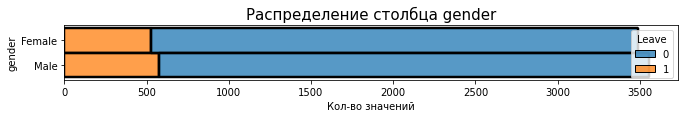

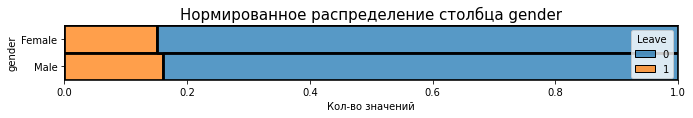

In [44]:
hist_cat('gender', norm=True)

Распределение по полу примерно одинаковое. Вероятно этот признак будет не очень полезным для модели.

#### SeniorCitizen

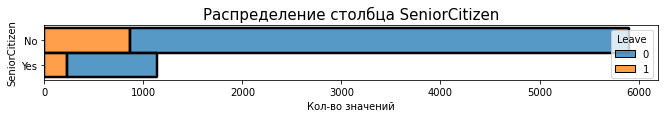

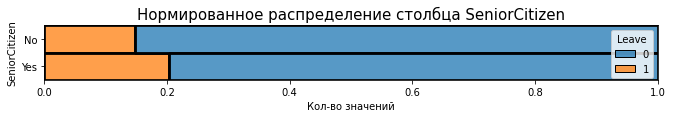

In [45]:
hist_cat('SeniorCitizen', norm=True)

Ожидаемо, клиентов с пенсионным статусом значительно меньше. Доли ушедших примерно одинаковы.

#### Partner

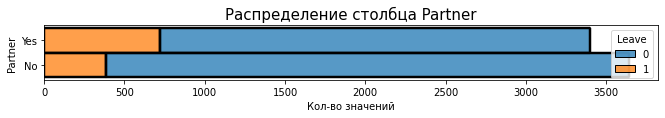

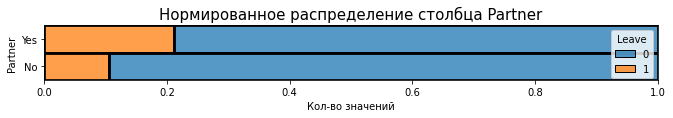

In [46]:
hist_cat('Partner', norm=True)

Видим интересную особенность. Клиентов с супругом немного меньше, но при этом ушедших среди них больше.

#### Dependents

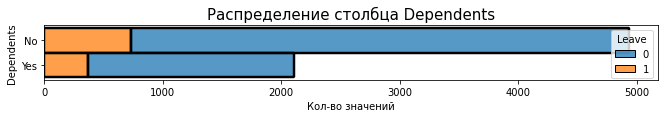

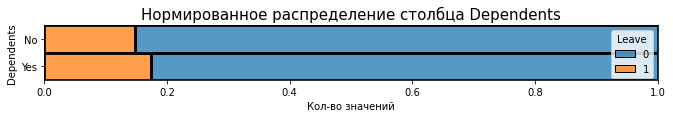

In [47]:
hist_cat('Dependents', norm=True)

Клиентов без иждевенцев значительно больше. При этом доли ушедших в обеих группах схожи.

#### InternetService

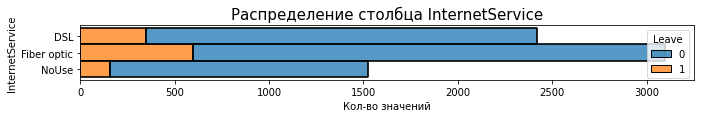

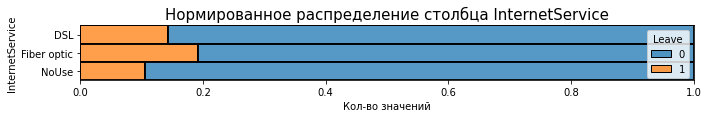

In [48]:
hist_cat('InternetService', norm=True)

Больше клиентвов использующих оптоволокно. Не использующих интернет меньшинство.

#### OnlineSecurity

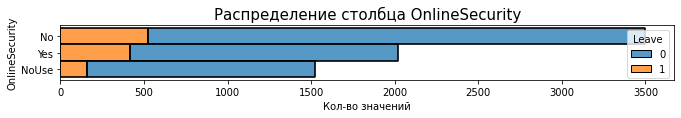

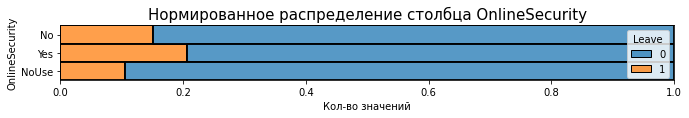

In [49]:
hist_cat('OnlineSecurity', norm=True)

Большая часть клиентов не использует межсетевой экран

#### OnlineBackup

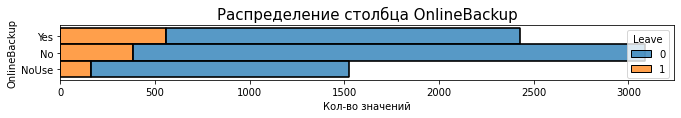

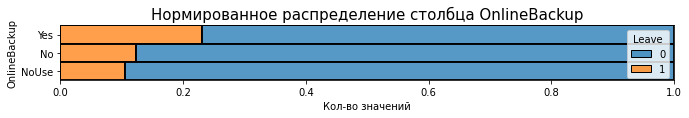

In [50]:
hist_cat('OnlineBackup', norm=True)

Интересно, что доля ушедших больше среди тех, кто использует облачное хранилище.

#### DeviceProtection

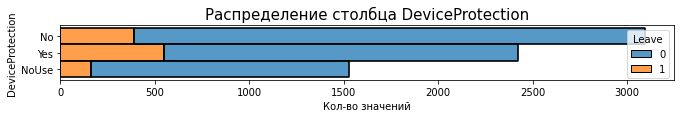

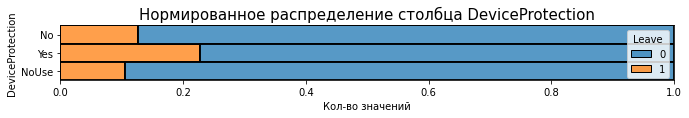

In [51]:
hist_cat('DeviceProtection', norm=True)

Аналогично, доля ушедших больше среди тех, кто использует антивирус.

#### TechSupport

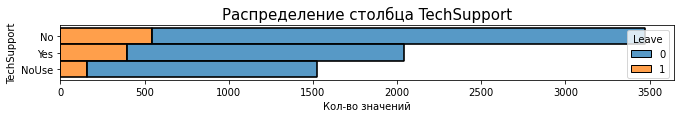

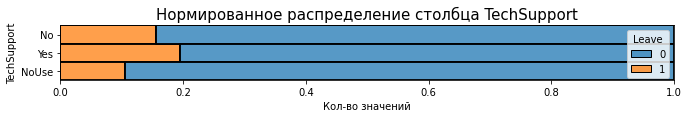

In [52]:
hist_cat('TechSupport', norm=True)

Большинство не использует выделенную линию технической поддержки.

#### StreamingTV

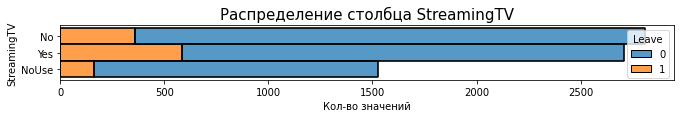

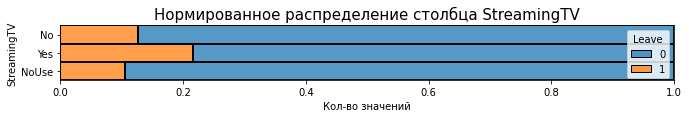

In [53]:
hist_cat('StreamingTV', norm=True)

Ушедших больше среди пользователей онлайн-ТВ.

#### StreamingMovies

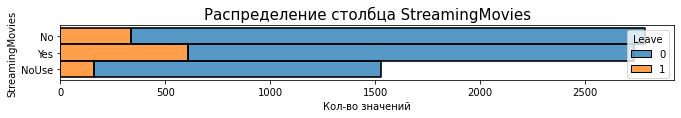

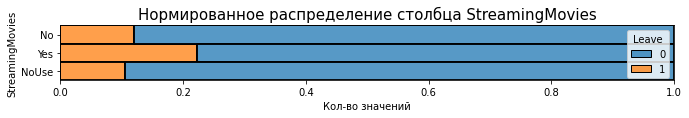

In [54]:
hist_cat('StreamingMovies', norm=True)

Анологично, ушедших больше и среди пользователей онлайн-кинотеатра.

#### MultipleLines

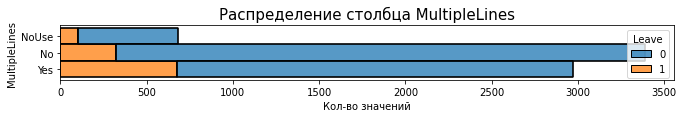

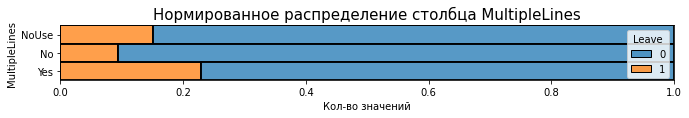

In [55]:
hist_cat('MultipleLines', norm=True)

Доля ушедших больше среди успользующих возможность подключения телефонного аппарата к нескольким линиям одновременно.

#### Days_of_use

Посмотрим на созданный нами признак

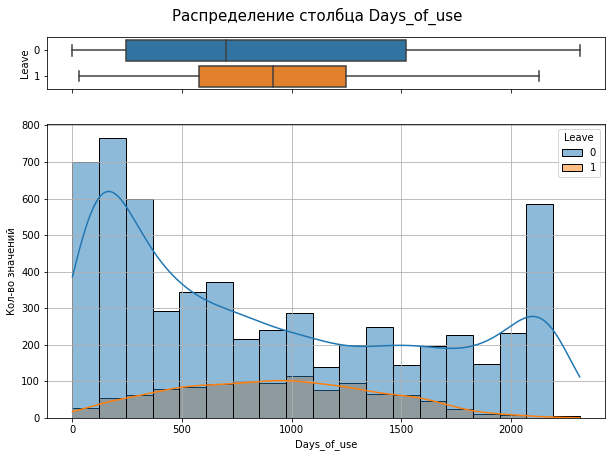

In [56]:
hist_n_box('Days_of_use')

Медианное значение около 600 дней использования. Большой пик у полугода использования. Также есть пик у 2100 дней. Последний показывает "лояльных" клиентов.

Медианное значение для ушедших около 800 дней.

### Баланс классов

Посмотрим на баланс классов целевого признака

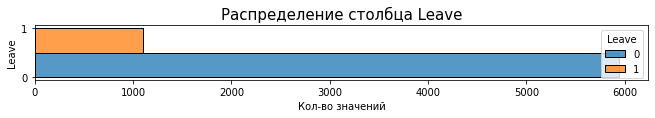

In [57]:
hist_cat('Leave')

In [58]:
df['Leave'].value_counts().to_frame()

,Leave
0,5942
1,1101


Видим значительный дисбаланс, надо будет учесть это при построении моделей.

### Корреляция признаков

In [59]:
phik_overview = df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'Days_of_use'])
phik_overview

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Leave,Days_of_use
BeginDate,1.000000,0.548313,0.766249,0.081447,0.456389,0.421886,0.774207,0.011268,0.050862,0.473514,...,0.192197,0.460712,0.496176,0.502422,0.455418,0.419599,0.431137,0.468035,0.450254,0.978521
EndDate,0.548313,1.000000,0.285429,0.062936,0.169262,0.173493,0.217670,0.018274,0.090502,0.177492,...,0.117099,0.166235,0.236373,0.225828,0.150303,0.185980,0.199118,0.249504,1.000000,0.396342
Type,0.766249,0.285429,1.000000,0.106860,0.277462,0.388444,0.470860,0.000000,0.086231,0.179736,...,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.244410,0.094015,0.634155
PaperlessBilling,0.081447,0.062936,0.106860,1.000000,0.370495,0.467812,0.201703,0.000000,0.242133,0.013218,...,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.099953,0.083398,0.026799
PaymentMethod,0.456389,0.169262,0.277462,0.370495,1.000000,0.399526,0.335666,0.000000,0.292725,0.243008,...,0.323886,0.315799,0.293413,0.297923,0.317713,0.284531,0.285525,0.174849,0.214832,0.350964
MonthlyCharges,0.421886,0.173493,0.388444,0.467812,0.399526,1.000000,0.710905,0.008175,0.304985,0.203545,...,0.919002,0.812632,0.818851,0.827272,0.816660,0.864677,0.863616,0.709983,0.226280,0.387727
TotalCharges,0.774207,0.217670,0.470860,0.201703,0.335666,0.710905,1.000000,0.000000,0.135650,0.381958,...,0.490081,0.516538,0.550544,0.558393,0.527838,0.555322,0.554030,0.467787,0.302890,0.848337
gender,0.011268,0.018274,0.000000,0.000000,0.000000,0.008175,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581,0.000000
SeniorCitizen,0.050862,0.090502,0.086231,0.242133,0.292725,0.304985,0.135650,0.000000,1.000000,0.016992,...,0.160702,0.127319,0.109995,0.110177,0.135283,0.111714,0.113778,0.087925,0.086159,0.063315
Partner,0.473514,0.177492,0.179736,0.013218,0.243008,0.203545,0.381958,0.000000,0.016992,1.000000,...,0.000000,0.091202,0.092012,0.100092,0.076326,0.082251,0.077506,0.086249,0.226688,0.453688


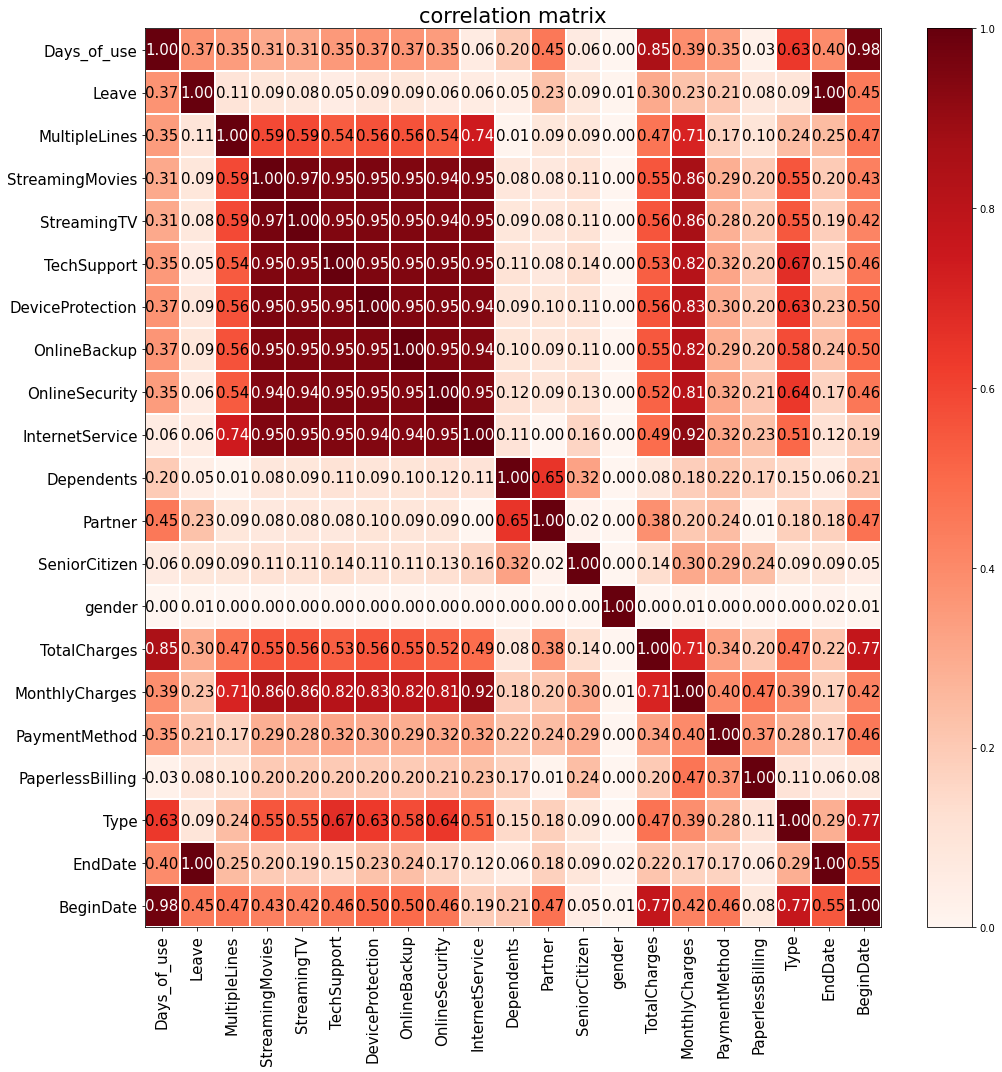

In [60]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Reds', title=r'correlation matrix', fontsize_factor=1.5,
                        figsize=(15,15))
plt.tight_layout()

Видим высокую корреляцию между синтетическим признаком Days_of_use и TotalCharges, чтобы избежать мультиколлинеарности, рекомендуется оставить Days_of_use, поскольку у него выше корр-ия с целевым.

Также высокая корреляция между признакми MonthlyCharges, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies. Среди них с целевым лучше всего корреллирует MonthlyCharges. Чтобы избежать мультиколлинеарности среди этих признаков лучше оставить MonthlyCharges.

Признак gender показывает 0-ю корреляцию, вероятно от него не будет смысла для модели.

### Вывод

Мы рассмотрели распределения и уникальные значения признаков. Отметим несколько особенностей:

- Больше ушедших среди тех, кто больше тратит за услуги.
- Среди разных типов оплаты меньше всего ушедших среди тех, кто получает чек по почте.
- Клиентов с супругом немного меньше, но при этом ушедших среди них больше.
- Среди тех, кто использует такие услуги как облачное хранилище, антивирус, онлайн-ТВ, онлайн-кинотеатр, несколько линий телефона доля ушедших больше.

Наблюдается сильный дисбаланс классов.

Исследована корреляция признаков, есть проблема мультиколлинеарности:

- Видим высокую корреляцию между синтетическим признаком Days_of_use и TotalCharges, рекомендуется оставить Days_of_use, поскольку у него выше корр-ия с целевым.
- Также высокая корреляция между признакми MonthlyCharges, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies. Среди них с целевым лучше всего корреллирует MonthlyCharges.
- Зависимости от признака gender нет.

## Отбор признаков

Удалим признаки 'EndDate', 'BeginDate', т.к. они приведут к утечке данных.

Также удалим признак 'gender', поскольку зависимости с ним нет.

In [61]:
df = df.drop(['EndDate', 'BeginDate', 'gender'], axis=1)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   SeniorCitizen     7043 non-null   object 
 6   Partner           7043 non-null   object 
 7   Dependents        7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  MultipleLines     7043 non-null   object 
 16  Leave             7043 non-null   int64  


## Обучение моделей

### Разбиение данных на выборки

Выделим в данных целевой признак

In [63]:
X = df.drop('Leave', axis=1)
y = df['Leave']

Разделим исходные данные на обучающую и тестовую выборки в соотношении 3:1

In [64]:
# сделаем разбиение со стратификацией с помощью параметра stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

Посмотрим на размеры получившихся выборок

In [65]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5282, 17) (5282,)
(1761, 17) (1761,)


Запишем в отдельные переменные категориальные и количественные признаки

In [66]:
cat_features = X_train.select_dtypes(include='object').columns.to_list()
cat_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [67]:
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features

['MonthlyCharges', 'TotalCharges', 'Days_of_use']

### Линейные модели

Скопируем признаки, поскольку для разных моделей потребуется разная обработка

In [68]:
X_train_line = X_train.copy()
X_test_line = X_test.copy()

#### Отбор признаков

Поскольку мультиколлинеарность отрицательно влияет на линеные модели, удалим выбранные в EDA признаки

In [69]:
multicoll_features = ['TotalCharges', 'InternetService', 'OnlineSecurity',
                      'OnlineBackup', 'DeviceProtection', 'TechSupport',
                      'StreamingTV', 'StreamingMovies']

In [70]:
X_train_line = X_train_line.drop(multicoll_features, axis=1)
X_test_line = X_test_line.drop(multicoll_features, axis=1)

In [71]:
X_train_line.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1058 to 2883
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   object 
 2   PaymentMethod     5282 non-null   object 
 3   MonthlyCharges    5282 non-null   float64
 4   SeniorCitizen     5282 non-null   object 
 5   Partner           5282 non-null   object 
 6   Dependents        5282 non-null   object 
 7   MultipleLines     5282 non-null   object 
 8   Days_of_use       5282 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 412.7+ KB


Уберем удаленные колонки из списков категориальных и численных признаков

In [72]:
num_features_line = num_features.copy()
num_features_line.remove('TotalCharges')
num_features_line

['MonthlyCharges', 'Days_of_use']

In [73]:
cat_features_line = cat_features.copy()
for col in [
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies']:
    cat_features_line.remove(col)
cat_features_line

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines']

#### Кодирование

Чтобы воспользоваться линейными моделями, категориальные признаки надо будет обратать и закодировать. Закодируем их с помощью OneHotEncoder. К тому же нам надо дополнительно масштабировать количественные признаки, для этого воспользуемся StandardScaler.

Создадим трансформер с этими кодировщиками, котрым будем пользоваться в пайплайнах линейных моделей.

In [71]:
# drop='first' удаляет первый признак из закодированных,
# чтобы избежать dummy-ловушку
# handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
col_transformer_line = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        cat_features_line
    ),
    (
        StandardScaler(), 
        num_features_line
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

Посмотрим, как будет выглядеть датафрейм после применения к нему нашего трансформера.

In [72]:
X_train_line_examp = pd.DataFrame(
    col_transformer_line.fit_transform(X_train_line),
    columns=col_transformer_line.get_feature_names_out()
)
get_info(X_train_line_examp)
del X_train_line_examp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Type_One year                          5282 non-null   float64
 1   Type_Two year                          5282 non-null   float64
 2   PaperlessBilling_Yes                   5282 non-null   float64
 3   PaymentMethod_Credit card (automatic)  5282 non-null   float64
 4   PaymentMethod_Electronic check         5282 non-null   float64
 5   PaymentMethod_Mailed check             5282 non-null   float64
 6   SeniorCitizen_Yes                      5282 non-null   float64
 7   Partner_Yes                            5282 non-null   float64
 8   Dependents_Yes                         5282 non-null   float64
 9   MultipleLines_NoUse                    5282 non-null   float64
 10  MultipleLines_Yes                      5282 non-null   float64
 11  Mont

,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,MultipleLines_NoUse,MultipleLines_Yes,MonthlyCharges,Days_of_use
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.817772,-1.095010
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.327166,-0.784411
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,-1.463300,0.689468
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.479902,-0.649623
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.375311,-1.004175


,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,MultipleLines_NoUse,MultipleLines_Yes,MonthlyCharges,Days_of_use
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5.282000e+03,5.282000e+03
mean,0.206361,0.239303,0.595608,0.218667,0.337751,0.225861,0.161492,0.486179,0.301969,0.096744,0.426732,-1.325037e-16,-8.609378e-17
std,0.404731,0.426699,0.490821,0.413381,0.472988,0.418188,0.368019,0.499856,0.459155,0.295636,0.494650,1.000095e+00,1.000095e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.549629e+00,-1.319169e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.627591e-01,-9.148043e-01
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.810973e-01,-2.042362e-01
75%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,8.327137e-01,8.213260e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.787311e+00,2.071047e+00


Кол-во дуликатов: 28


#### LogisticRegression

In [73]:
%%time
lr_model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

pipeline_lr = Pipeline(steps=[
    ('preprocessor', col_transformer_line),
    ('lr', lr_model)
])

parametrs_lr = {
    #'lr__penalty' : ['l2', 'none'],
    'lr__C' : np.arange(0.1, 1.01, 0.1)
}

grid_lr = GridSearchCV(
    pipeline_lr, 
    param_grid=parametrs_lr, 
    cv=3,
    scoring = 'roc_auc',
)

grid_lr.fit(X_train_line, y_train)
print('Подобранные параметры', grid_lr.best_params_)
print('Лучшее ROC-AUC:', grid_lr.best_score_)

Подобранные параметры {'lr__C': 1.0}
Лучшее ROC-AUC: 0.7534965162578247
CPU times: user 5.24 s, sys: 6.32 s, total: 11.6 s
Wall time: 11.5 s


#### RidgeClassifier

In [74]:
%%time
ridge_model = RidgeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

pipeline_ridge = Pipeline(steps=[
    ('preprocessor', col_transformer_line),
    ('ridge', ridge_model)
])

parametrs_ridge = {
    'ridge__alpha': np.arange(0, 1, 0.05)
}

grid_ridge = RandomizedSearchCV(
    pipeline_ridge, 
    param_distributions=parametrs_ridge, 
    cv=3,
    scoring = 'roc_auc',
    random_state=RANDOM_STATE
)

grid_ridge.fit(X_train_line, y_train)
print('Подобранные параметры', grid_ridge.best_params_)
print('Лучшее ROC-AUC:', grid_ridge.best_score_)

Подобранные параметры {'ridge__alpha': 0.8}
Лучшее ROC-AUC: 0.753368686240786
CPU times: user 3.92 s, sys: 4.6 s, total: 8.52 s
Wall time: 8.52 s


### Деревянные модели

Заново скопируем признаки

In [75]:
X_train_trees = X_train.copy()
X_test_trees = X_test.copy()

#### Кодирование

Для деревянных моделей можно воспользоваться аналогичным трансформером с OneHotEncoder и StandardScaler, который мы создали для линейных моделей. 

Однако, для деревянных моделей лучше использовать OrdinalEncoder вместо OneHotEncoder.

Численные признаки можно и не масштабировать, но это и не повредит моделям.

К мультиколлинеарности деревянные модели не так восприимчивы, поэтому попробуем не удалять признаки с высокой корреляцией.

In [76]:
# handle_unknown='use_encoded_value' : закодированное значение неизвестных
# категорий будет установлено равным значению, заданному для параметра unknown_value
col_transformer_trees = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        cat_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

#### DecisionTreeClassifier

In [77]:
%%time
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

pipeline_dt = Pipeline(steps=[
    ('preprocessor', col_transformer_trees),
    ('dt', dt_model)
])

parametrs_dt = {
    'dt__max_depth': range(1, 10),
    'dt__min_samples_split': (2, 3, 4),
    'dt__min_samples_leaf': (1, 2, 3, 4)
}

grid_dt = RandomizedSearchCV(
    pipeline_dt, 
    param_distributions=parametrs_dt, 
    cv=3,
    scoring = 'roc_auc',
    random_state=RANDOM_STATE
)

grid_dt.fit(X_train_trees, y_train)
print('Подобранные параметры', grid_dt.best_params_)
print('Лучшее ROC-AUC:', grid_dt.best_score_)

Подобранные параметры {'dt__min_samples_split': 2, 'dt__min_samples_leaf': 1, 'dt__max_depth': 5}
Лучшее ROC-AUC: 0.7869539213837927
CPU times: user 1.1 s, sys: 1.51 ms, total: 1.1 s
Wall time: 1.11 s


#### RandomForestClassifier

In [78]:
%%time
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

pipeline_rf = Pipeline(steps=[
    ('preprocessor', col_transformer_trees),
    ('dt', rf_model)
])

parametrs_rf = {
    'dt__max_depth': range(1, 10),
    'dt__n_estimators': range(100, 221, 20),
    'dt__min_samples_split': (2, 3, 4),
    'dt__min_samples_leaf': (1, 2, 3, 4)
}

grid_rf = RandomizedSearchCV(
    pipeline_rf, 
    param_distributions=parametrs_rf, 
    cv=3,
    scoring = 'roc_auc',
    random_state=RANDOM_STATE
)

grid_rf.fit(X_train_trees, y_train)
print('Подобранные параметры', grid_rf.best_params_)
print('Лучшее ROC-AUC:', grid_rf.best_score_)

Подобранные параметры {'dt__n_estimators': 140, 'dt__min_samples_split': 2, 'dt__min_samples_leaf': 3, 'dt__max_depth': 7}
Лучшее ROC-AUC: 0.8259322862092593
CPU times: user 13 s, sys: 30.9 ms, total: 13 s
Wall time: 13.2 s


### Бустинг-модели

Скопируем признаки

In [79]:
X_train_boost = X_train.copy()
X_test_boost = X_test.copy()

LightGBM и CatBoost умеют работать с категориальными переменными, поэтому нам не нужно их кодировать, но нужно сменить их тип.

In [80]:
X_train_boost[cat_features] = X_train_boost[cat_features].astype('category')
X_test_boost[cat_features] = X_test_boost[cat_features].astype('category')

In [81]:
X_train_boost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1058 to 2883
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              5282 non-null   category
 1   PaperlessBilling  5282 non-null   category
 2   PaymentMethod     5282 non-null   category
 3   MonthlyCharges    5282 non-null   float64 
 4   TotalCharges      5282 non-null   float64 
 5   SeniorCitizen     5282 non-null   category
 6   Partner           5282 non-null   category
 7   Dependents        5282 non-null   category
 8   InternetService   5282 non-null   category
 9   OnlineSecurity    5282 non-null   category
 10  OnlineBackup      5282 non-null   category
 11  DeviceProtection  5282 non-null   category
 12  TechSupport       5282 non-null   category
 13  StreamingTV       5282 non-null   category
 14  StreamingMovies   5282 non-null   category
 15  MultipleLines     5282 non-null   category
 16  Days_of_use       528

#### CatBoostClassifier

In [82]:
%%time
cat_model = CatBoostClassifier(random_state=RANDOM_STATE, auto_class_weights='Balanced')

parametrs_cat = {
    'max_depth': range(1, 10), #[3]
    'iterations': range(300, 501, 10), #[390]
    'learning_rate': np.arange(0.1, 0.4, 0.01) #[0.26]
}

grid_cat = RandomizedSearchCV(
    cat_model,
    param_distributions=parametrs_cat, 
    cv=3,
    scoring = 'roc_auc',
    random_state=RANDOM_STATE
)

grid_cat.fit(
    X_train_boost,
    y_train,
    cat_features=cat_features,
    verbose=False
)

print('Подобранные параметры', grid_cat.best_params_)
print('Лучшее ROC-AUC:', grid_cat.best_score_)

Подобранные параметры {'max_depth': 3, 'learning_rate': 0.32999999999999985, 'iterations': 360}
Лучшее ROC-AUC: 0.8875783265221217
CPU times: user 2min 18s, sys: 33.2 s, total: 2min 51s
Wall time: 3min 16s


#### LGBMClassifier

In [83]:
%%time
lgbm_model = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced', metric='auc')

parametrs_lgbm = {
    'learning_rate': np.arange(0.01, 0.3, 0.01), #[0.23],
    'n_estimators': range(200, 401, 10), #[370],
    'max_depth': range(1, 10) #[2]
}

grid_lgbm = RandomizedSearchCV(
    lgbm_model, 
    param_distributions=parametrs_lgbm, 
    cv=3,
    scoring = 'roc_auc',
    random_state=RANDOM_STATE
)

grid_lgbm.fit(
    X_train_boost,
    y_train
)

print('Подобранные параметры', grid_lgbm.best_params_)
print('Лучшее ROC-AUC:', grid_lgbm.best_score_)

Подобранные параметры {'n_estimators': 370, 'max_depth': 2, 'learning_rate': 0.23}
Лучшее ROC-AUC: 0.8730564742023592
CPU times: user 53.1 s, sys: 0 ns, total: 53.1 s
Wall time: 53.7 s


### Вывод

Посмотрим на полученные результаты после тренировок моделей

In [84]:
result = pd.DataFrame(
    [grid_lr.best_score_, grid_ridge.best_score_, grid_dt.best_score_,
     grid_rf.best_score_, grid_cat.best_score_, grid_lgbm.best_score_], 
    index=['LogisticRegression', 'RidgeClassifier',
           'DecisionTreeClassifier', 'RandomForestClassifier',
           'CatBoostClassifier', 'LGBMClassifier'], 
    columns=['ROC-AUC']
)
result

,ROC-AUC
LogisticRegression,0.753497
RidgeClassifier,0.753369
DecisionTreeClassifier,0.786954
RandomForestClassifier,0.825932
CatBoostClassifier,0.887578
LGBMClassifier,0.873056


- Итак, мы обучили несколько моделей ориентируясь на метрику ROC-AUC.
- Как видим, ROC-AUC у линейных моделей имеет самые низкие значения. Рассматривать их для нашей задачи не стоит.
- Так же и модель DecisionTree. Результат которой не сильно отличается.
- Модель RandomForest уже ближе к требуемому результату.
- Лучшие значения метрики, ожидаемо, у бустинг-моделей.
- Самое высокое значение метрики у CatBoostClassifier, поэтому рекомендованной моделью является она.

## Проверка лучшей модели на тестовой выбоке

### ROC-AUC на тестовой выбоке

Посчитаем метрику ROC-AUC нашей модели на тестовой выбоке

In [85]:
best_model = grid_cat.best_estimator_

In [86]:
auc_roc = roc_auc_score(y_test, best_model.predict_proba(X_test_boost)[:,1])
print('ROC-AUC выбранной модели на тестовой выборке:', auc_roc)

ROC-AUC выбранной модели на тестовой выборке: 0.9176459072555978


### ROC-кривая

Построим ROC-кривую

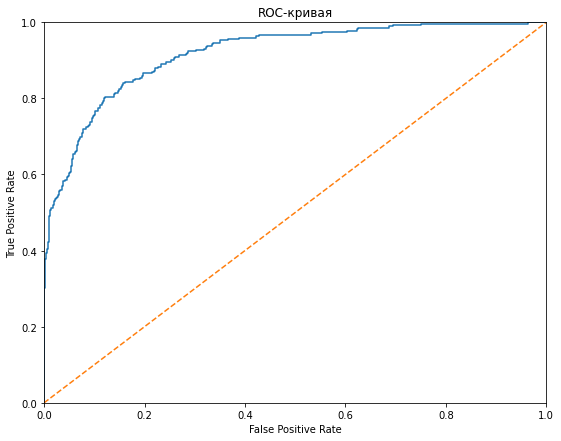

In [87]:
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test_boost)[:, 1])

plt.figure(figsize=(9, 7))

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
# устанавливаем границы осей от 0 до 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Чем ближе ROC-кривыая проходит к левому верхнему углу и дальше от пунктирной линии, тем модель лучше. Метрика ROC-AUC показывает площадь под кривой. Значение выше 0,8 считается очень хорошим.

### Accuracy на тестовой выбоке

In [88]:
y_pred = best_model.predict(X_test_boost)
acc = accuracy_score(y_test, y_pred)
print('Accuracy выбранной модели на тестовой выборке:', acc)

Accuracy выбранной модели на тестовой выборке: 0.8580352072685974


Модель предсказывает класс целевого признака с точностью приблизительно 0,87.

### Матрица ошибок

Изобразим матрицу ошибок

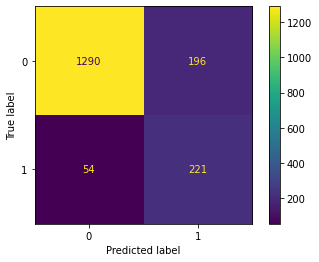

In [89]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

Как видим модель правильно предсказала 1336 отрицательных и 203 положительных значений.

При этом модель сделала довольно много ложноположительных предсказаний (150). Ложноотрицательных в 2 раза меньше.

Для задачи предсказания ухода клиента, вероятно, ложноположительные предсказания менее критичны, чем ложноотрицательные. Потому что лучше ошибочно сделать неуходящему клиенту спецпредложение, чем не среагировать на уходящего.

### Оценка важности признаков

Посмотрим на степень важности признаков для модели

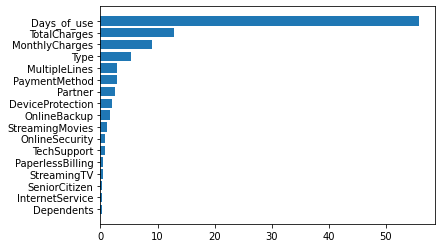

In [90]:
importances = best_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train_boost.columns)[indices])

Как видим, самым важным признаком с большим отрывом для модели оказался созданный нами Days_of_use.

Среди изначальных признаков самые значимые TotalCharges, MonthlyCharges и Type.

### Проверка модели на адекватность

Проверим нашу модель на адекватность. Для этого сравним предсказания нашей модели с предскаханиями полученными фиктивной константной моделью DummyClassifier.

In [91]:
dummy_clf = DummyClassifier(random_state=42, strategy='constant', constant=0)
dummy_clf.fit(X_train, y_train)

predictions_dummy_test = dummy_clf.predict(X_test)

print('DummyClassifier:')
print('Accuracy:', round(accuracy_score(y_test, predictions_dummy_test), 3))
print('AUC-ROC:', round(roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:, 1]), 3))

DummyClassifier:
Accuracy: 0.844
AUC-ROC: 0.5


Метрики нашей итоговой модели лучше, чем у фиктивной, модель адекватна.

### Вывод

- Лучшей моделью выбрана CatBoostClassifier.
- ROC-AUC модели на тестовой выборке составляет 0.92
- Accuracy модели на тестовой выборке: 0.87
- Модель сделала ложноположительных предсказаний в 2 раза больше чем ложноотрицательных, что не плохо для нашей задачи.
- Самым важным признаком для модели оказался созданный нами Days_of_use. 
- Среди изначальных признаков самые значимые TotalCharges, MonthlyCharges и Type.

## Отчет

### Выполнение плана

Итак, мы выполнили все пункты плана, а именно:

Подготовка:
- Данные были загружены и изучены
- Таблицы объеденены в одну
- Возникшие пропуски были заполнены новой категорией
- Создан цевой признак на основе даты ухода клиента, а также дополнителный признак продолжительности пользования услугами

EDA:
- Все признаки были ииследованы
- Обнаружен дисбаланс классов
- Найдены мультиколлинеарные признаки

Отбор признаков:
- Признаки содержащие абсолютные даты были удалены
- Удален признаки 'customerID' и 'gender', не несущие полезной информации
- Для линейных моделей были такжи удалены 'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies' из-зи мультиколлинеарности.

Обучение моделей:
- Были обучены 6 моделей 3 разных типов
- Для предотвращения утечки данных обучение проводилось с использованием кросс-валидации и пайплайнов
- Для линейных моделей логистической регрессии и Ridge категриальные признаки были закодированы с помощью OHE, а численные отмасштабированы
- Для моделей решающего дерева и случайного леса было выбрано OE-кодирование и также масштабирование
- Для CatBoost и LGBM дополнительная предобработка не потребовалась
- По метрике ROC-AUC лучшей моделью была выбрана CatBoost

Проверка лучшей модели:
- Выбранная модель была проверена на тестовой выборке
- Построена ROC-кривая, вычислены accuracy и матрица ошибок, оценена важность признаков


### Трудности


При построении моделей не сразу удалось достичь требуемой метрики. Главным решением оказалось замена созданного признака продолжительности пользования услугами в месяцах, на этот же признак в днях. Несмотря на кажущуюся незначительной разницу, это позволило моделям на основе деревьев вычленить больше зависимостей среди признаков и улучшить метрики.

### Ключевые шаги

- EDA
- Создание новых признаков, в том числе целевого
- Кодирование признаков
- Обучение моделей
- Анализ обученных моделей

### Итоговая модель

Итоговой моделью была выбрана CatBoost с гиперпараметрами 
- max_depth = 3, 
- learning_rate = 0.33, 
- iterations = 360,
- auto_class_weights = 'Balanced'

Полученные метрики:
- ROC-AUC модели на валидации составляет 0.89
- ROC-AUC на тестовой выборке составляет 0.92
- Accuracy модели на тестовой выборке: 0.87

Для обучения модели были, в итоге, использованы признаки 'Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'MonthlyCharges', 'TotalCharges', 'Days_of_use'.

Самым важным признаком с большим отрывом для модели оказался созданный нами 'Days_of_use'. Среди изначальных признаков самые значимые 'TotalCharges', 'MonthlyCharges' и 'Type'.

Рекоммендации:

Модель показывает признаки переобучения. В будещем рекоммендуется более тщательно поработать с признаком продолжительности пользования услугами, чтобы улучшить устойчивости модели.

Ещё можно попросить у заказчика доплнительные данные, которые дадут больше обезличенной, но персонифицированной информации о пользовании клиентов услугами, чтобы было больше свободы в создании признаков.